# Time-series Anomaly Detection. transformer&gru model with HAI

220517

[URL](https://dacon.io/competitions/official/235757/codeshare/3086?page=2&dtype=recent)

GRU, pytorch code

# 모델 선택!

- 1) Trnaformer
- 2) GRU

In [1]:
# config
model_type = 'transformer'
# model_type = 'gru'


# 0_데이터 준비

- 1) 아래 URL에서 데이터를 다운로드
- 2) 235757_HAICon2021_dataset.zip 파일을 colab에 upload, 그런데 너무 오래걸려요! 이번엔 구글 드라이브에 연동해 봅시다

- 3) 구글 드라이브에 다운받은 235757_HAICon2021_dataset.zip 파일을 업로드 후 아래 코드를 실행

- [DATA DOWNLOAD URL](https://dacon.io/competitions/official/235757/data)

In [2]:
# 구글 드라이브 colab과 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# MyDrive 폴더 안에 235757_HAICon2021_dataset.zip 파일이 잘 업로드 되어있나요?
!ls /content/drive/MyDrive/

 0000.zip  '200924_축의금 목록.xlsx'	   'My Drive'
 000.zip    235757_HAICon2021_dataset.zip   YOLOv5_test
 0.zip	   'Colab Notebooks'		   '강아지 그림 사진.zip'


In [4]:
# 그럼 이 코드로 colab으로 가져옵니다. 엄청 빠릅니다.
!cp /content/drive/MyDrive/235757_HAICon2021_dataset.zip .

In [5]:
# data 폴더를 만든 후 그 안에 압축을 풉시다
import os
# 파일이 이미 있으면 pass
if not os.path.exists('data/train'):
    !mkdir ./data
    !mv 235757_HAICon2021_dataset.zip ./data/
    %cd ./data
    !unzip ./235757_HAICon2021_dataset.zip
    %cd ..


/content/data
Archive:  ./235757_HAICon2021_dataset.zip
  inflating: eTaPR-21.8.2-py3-none-any.whl  
  inflating: sample_submission.csv   
   creating: test/
  inflating: test/test1.csv          
  inflating: test/test2.csv          
  inflating: test/test3.csv          
   creating: train/
  inflating: train/train1.csv        
  inflating: train/train2.csv        
  inflating: train/train3.csv        
  inflating: train/train4.csv        
  inflating: train/train5.csv        
  inflating: train/train6.csv        
   creating: validation/
  inflating: validation/validation.csv  
/content


## model_type을 transformer나 gru 중 고를 수 있다!
### 어떤 모델이 더 빠르고 성능이 좋은가요??

In [6]:
if model_type == 'gru':
    batch_size = 4096
    epochs = 100  # 20min
elif model_type == 'transformer':
    batch_size = 512
    epochs = 20  # 1hour

device = 'cuda'
WINDOW_SIZE = 90  # 89개의 데이터를 보고 다음 한개를 예측
stride = 10  # 데이터 슬라이딩 크기, 1등은 1로 뒀음
# ready = True  # 미리 데이터 처리를 해놓으면 True
ready = False  # 미리 데이터 처리를 해놓으면 True

In [8]:
## setup
!python -m pip install data/eTaPR-21.8.2-py3-none-any.whl  # TaPR은 평가 metric 설치
!pip install watermark 
%reload_ext watermark
%watermark -v -p dateutil,numpy,matplotlib,pandas,torch,tqdm,TaPR_pkg,cv2

Processing ./data/eTaPR-21.8.2-py3-none-any.whl
eTaPR is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.
Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

dateutil  : 2.8.2
numpy     : 1.21.6
matplotlib: 3.2.2
pandas    : 1.3.5
torch     : 1.11.0+cu113
tqdm      : 4.64.0
TaPR_pkg  : unknown
cv2       : 4.1.2



In [9]:
# import
import sys
import os
import random
from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr

In [10]:
# 사용할 GPU 설정
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # PCI_BUS_ID 기준으로 control하겠다는 의미인듯.
os.environ["CUDA_VISIBLE_DEVICES"]="0" # [number]는 GPU 번호. (복수도 가능 ex. "1,2")
print(torch.cuda.is_available())

# seed 고정을 위한 함수 정의
def seed_everything(seed = 777):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

True


## 1_데이터 전처리

학습 데이터와 테스트 데이터는 CSV로 제공됩니다.
HAI 2.0은 단일 파일이 아니라 여러 파일로 제공되기 때문에 디렉토리 안에 있는 모든 CSV를 읽습니다.

In [11]:
## data process functions
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [12]:
## data processing

TIMESTAMP_FIELD = "timestamp"
DROP_FIELD = ["timestamp", 
              "C02", "C03", "C14", "C18", "C19", "C21", "C22", "C25", "C33", "C34", "C35", "C37", "C40", "C43", "C51", "C52", "C59", "C61", "C63", "C64", "C65", "C67",
              "C04", "C05", "C06", "C07", "C08", "C10", "C11", "C17", "C24", "C28", "C32", "C44", "C46", "C48", "C49", "C50", "C53", "C58", "C62", "C71", "C76", "C78", "C79"]
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
    
if not ready:
    TRAIN_DATASET = sorted([x for x in Path("data/train/").glob("*.csv")])
    TEST_DATASET = sorted([x for x in Path("data/test/").glob("*.csv")])
    VALIDATION_DATASET = sorted([x for x in Path("data/validation/").glob("*.csv")])
    print(TRAIN_DATASET)
    print(TEST_DATASET)
    print(VALIDATION_DATASET)

    TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
    TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
    VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)

    VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop(DROP_FIELD) # DROP_FIELD를 통해 normalization에 사용하지 않을 변수를 제거함.
    TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()  # 각 열의 최소값
    TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()  # 각 열의 최대값

    # 각 필드가 가지는 값의 범위가 다르므로 정규화, Min-Max Normalize(0~1)
    # 정규화 후 exponential weighted function를 통과시켜 센서에서 발생하는 noise를 smoothing
    TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
    VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])
    TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
    print('load & normalize complete')

    # Boundary Check, 데이터 중 0~1이 아닌 값이 있는지 체크.1 초과/0 미만/NaN
    print('train data check:', boundary_check(TRAIN_DF))
    print('test  data check:', boundary_check(TEST_DF))
    print('valid data check:', boundary_check(VALIDATION_DF))  # 공격 데이터셋에서는 확실히 정상 데이터의 최솟값과 최댓값을 벗어나는 값이 나타남

[PosixPath('data/train/train1.csv'), PosixPath('data/train/train2.csv'), PosixPath('data/train/train3.csv'), PosixPath('data/train/train4.csv'), PosixPath('data/train/train5.csv'), PosixPath('data/train/train6.csv')]
[PosixPath('data/test/test1.csv'), PosixPath('data/test/test2.csv'), PosixPath('data/test/test3.csv')]
[PosixPath('data/validation/validation.csv')]
load & normalize complete
train data check: (False, False, False)
test  data check: (True, True, False)
valid data check: (True, True, False)


## 2_데이터 입출력 정의

- 베이스라인 모델은 Stacked RNN(GRU cells)을 이용해서 이상을 탐지
- 정상 데이터로 학습, label이 없으므로 unsupervised learning
- 슬라이딩 윈도우를 통해 시계열 데이터의 일부를 가져와서 해당 윈도우의 패턴을 기억
- 슬라이딩 윈도우는 90초(HAI는 1초마다 샘플링되어 있습니다)로 설정했습니다.

- 모델의 입출력
    - 입력 : 윈도우의 앞부분 89초에 해당하는 값
    - 출력 : 윈도우의 가장 마지막 초(90번째 초)의 값

- inference 시 모델이 출력하는 값(예측값)과 실제로 들어온 값의 차이가 크면 이상으로 간주
- 오차가 크면 학습 데이터셋에서 본 적이 없는 패턴

In [13]:
#### dataset 선언, 2min
class HaiDataset(Dataset):
    def __init__(self, timestamps, df, WINDOW_SIZE=90, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        self.WINDOW_SIZE = WINDOW_SIZE
        
        for L in trange(len(self.ts) - self.WINDOW_SIZE + 1):
            R = L + self.WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=self.WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + self.WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + self.WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + self.WINDOW_SIZE - 1])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

if not ready:
    HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, WINDOW_SIZE=WINDOW_SIZE, stride=stride)
    # 모든 데이터 포인트에 대해 점검해야 하므로 validation/test 데이터의 stride 크기는 1
    HAI_DATASET_VALIDATION = HaiDataset(VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, WINDOW_SIZE=WINDOW_SIZE, stride=1, attacks=VALIDATION_DF_RAW[ATTACK_FIELD])
    HAI_DATASET_TEST = HaiDataset(TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, WINDOW_SIZE=WINDOW_SIZE, stride=1, attacks=None)

    with open('data.pickle', 'wb') as f:
        pickle.dump([HAI_DATASET_TRAIN, HAI_DATASET_VALIDATION, HAI_DATASET_TEST, TRAIN_DF, VALIDATION_DF, TEST_DF, TRAIN_DF_RAW, TEST_DF_RAW, VALIDATION_DF_RAW], f, pickle.HIGHEST_PROTOCOL)

# load
with open('data.pickle', 'rb') as f:
    [HAI_DATASET_TRAIN, HAI_DATASET_VALIDATION, HAI_DATASET_TEST, TRAIN_DF, VALIDATION_DF, TEST_DF, TRAIN_DF_RAW, TEST_DF_RAW, VALIDATION_DF_RAW] = pickle.load(f)
    
HAI_DATASET_TRAIN[0]

  0%|          | 0/1004313 [00:00<?, ?it/s]

# of valid windows: 100387


  0%|          | 0/86311 [00:00<?, ?it/s]

# of valid windows: 86311


  0%|          | 0/274711 [00:00<?, ?it/s]

# of valid windows: 274533


{'answer': tensor([0.3711, 0.0000, 0.6224, 0.4866, 0.2524, 0.2907, 0.3050, 0.3492, 0.0000,
         0.3563, 0.0000, 0.9763, 0.5501, 0.0000, 0.0000, 0.0000, 0.2642, 0.5416,
         0.0021, 0.5253, 0.0509, 0.0000, 0.3105, 0.7985, 0.4340, 0.2261, 0.2123,
         0.0000, 0.4706, 0.1565, 0.4803, 0.1081, 0.2816, 0.2480, 0.1132, 0.5313,
         0.0000, 0.5381, 0.0000, 0.0000, 0.0091]),
 'given': tensor([[0.4331, 0.0000, 0.5019,  ..., 0.0000, 0.0000, 0.2761],
         [0.3951, 0.0000, 0.5021,  ..., 0.0000, 0.0000, 0.2752],
         [0.3333, 0.0000, 0.5021,  ..., 0.0000, 0.0000, 0.2749],
         ...,
         [0.3205, 0.0000, 0.6222,  ..., 0.0000, 0.0000, 0.0091],
         [0.4451, 0.0000, 0.6222,  ..., 0.0000, 0.0000, 0.0091],
         [0.3477, 0.0000, 0.6222,  ..., 0.0000, 0.0000, 0.0091]]),
 'ts': '2021-07-11 10:01:29'}

## 3_define model

In [14]:
# 3.1. define GRU model

if model_type == 'gru':
    N_HIDDENS = 100  # Hidden cell
    N_LAYERS = 3  # 3층 bidirectional GRU

    class StackedGRU(torch.nn.Module):
        def __init__(self, n_tags):
            super().__init__()
            self.rnn = torch.nn.GRU(
                input_size=n_tags,
                hidden_size=N_HIDDENS,
                num_layers=N_LAYERS,
                bidirectional=True,
                dropout=0,
            )
            self.fc = torch.nn.Linear(N_HIDDENS * 2, n_tags)

        def forward(self, x):
            x = x.transpose(0, 1)  # (batch, seq, params) -> (seq, batch, params)
            self.rnn.flatten_parameters()
            outs, _ = self.rnn(x)
            out = self.fc(outs[-1])
    #         out = self.fc(self.relu(outs[-1]))  # 1등 코드        
            return x[0] + out  # 모델이 윈도우의 가장 첫 번째 값과 GRU의 출력을 더해서 내보내도록 skip connection


    MODEL = StackedGRU(n_tags=TRAIN_DF.shape[1])
    MODEL.to(device)

In [15]:
# 3.2. define transformer model
'''
데이콘에서 제공한 StackedGRU가 아닌 Transformer 모델
transformer의 경우 input sequence가 길 경우 기존 GRU에 비해 상대적으로 학습에 효율적이며 self-attention을 사용해 한번에 전체 맥락 파악
github에 공개된 Transformer pytorch source code 사용
encoder layer 구조만 사용했으며 기존 word_embbding 대신 linear_emb 변경
'''
if model_type == 'transformer':
    
    import torch
    import torch.nn as nn
    import torch.nn.functional as F


    class ScaledDotProductAttention(nn.Module):
        ''' Scaled Dot-Product Attention '''
        def __init__(self, temperature, attn_dropout=0.1):
            super().__init__()
            self.temperature = temperature
            self.dropout = nn.Dropout(attn_dropout)

        def forward(self, q, k, v, mask=None):

            attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

            if mask is not None:
                attn = attn.masked_fill(mask == 0, -1e9)

            attn = self.dropout(F.softmax(attn, dim=-1))
            output = torch.matmul(attn, v)

            return output, attn


    def get_subsequent_mask(seq):
        ''' For masking out the subsequent info. '''
        sz_b, len_s = seq.size()
        subsequent_mask = (1 - torch.triu(torch.ones(
            (1, len_s, len_s), device=seq.device),
                                          diagonal=1)).bool()
        return subsequent_mask


    class MultiHeadAttention(nn.Module):
        ''' Multi-Head Attention module '''
        def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
            super().__init__()

            self.n_head = n_head
            self.d_k = d_k
            self.d_v = d_v

            self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
            self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
            self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
            self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

            self.attention = ScaledDotProductAttention(temperature=d_k**0.5)

            self.dropout = nn.Dropout(dropout)
            self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        def forward(self, q, k, v, mask=None):

            d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
            sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

            residual = q

            # Pass through the pre-attention projection: b x lq x (n*dv)
            # Separate different heads: b x lq x n x dv
            q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
            k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
            v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

            # Transpose for attention dot product: b x n x lq x dv
            q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

            if mask is not None:
                mask = mask.unsqueeze(1)  # For head axis broadcasting.

            q, attn = self.attention(q, k, v, mask=mask)

            # Transpose to move the head dimension back: b x lq x n x dv
            # Combine the last two dimensions to concatenate all the heads together: b x lq x (n*dv)
            q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
            q = self.dropout(self.fc(q))
            q += residual

            q = self.layer_norm(q)

            return q, attn


    class PositionwiseFeedForward(nn.Module):
        ''' A two-feed-forward-layer module '''
        def __init__(self, d_in, d_hid, dropout=0.1):
            super().__init__()
            self.w_1 = nn.Linear(d_in, d_hid)  # position-wise
            self.w_2 = nn.Linear(d_hid, d_in)  # position-wise
            self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
            self.dropout = nn.Dropout(dropout)

        def forward(self, x):

            residual = x

            x = self.w_2(F.relu(self.w_1(x)))
            x = self.dropout(x)
            x += residual

            x = self.layer_norm(x)

            return x


    class PositionalEncoding(nn.Module):
        def __init__(self, d_hid, n_position=86):
            super(PositionalEncoding, self).__init__()

            # Not a parameter
            self.register_buffer(
                'pos_table', self._get_sinusoid_encoding_table(n_position, d_hid))

        def _get_sinusoid_encoding_table(self, n_position, d_hid):
            ''' Sinusoid position encoding table '''

            # TODO: make it with torch instead of numpy

            def get_position_angle_vec(position):
                return [
                    position / np.power(10000, 2 * (hid_j // 2) / d_hid)
                    for hid_j in range(d_hid)
                ]

            sinusoid_table = np.array(
                [get_position_angle_vec(pos_i) for pos_i in range(n_position)])
            sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
            sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

            return torch.FloatTensor(sinusoid_table).unsqueeze(0)

        def forward(self, x):
            return x + self.pos_table[:, :x.size(1)].clone().detach()


    class EncoderLayer(nn.Module):
        ''' Compose with two layers '''
        def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
            super(EncoderLayer, self).__init__()
            self.slf_attn = MultiHeadAttention(n_head,
                                               d_model,
                                               d_k,
                                               d_v,
                                               dropout=dropout)
            self.pos_ffn = PositionwiseFeedForward(d_model,
                                                   d_inner,
                                                   dropout=dropout)

        def forward(self, enc_input, slf_attn_mask=None):
            enc_output, enc_slf_attn = self.slf_attn(enc_input,
                                                     enc_input,
                                                     enc_input,
                                                     mask=slf_attn_mask)
            enc_output = self.pos_ffn(enc_output)

            return enc_output, enc_slf_attn


    class Encoder(nn.Module):
        ''' A encoder model with self attention mechanism. '''
        def __init__(
            self,
            n_src_vocab,
            d_word_vec,
            n_layers,
            n_head,
            d_k,
            d_v,
            d_model,
            d_inner,
            dropout=0.1,
            n_position=89,
            scale_emb=False,
        ):

            super().__init__()

            self.src_emb = nn.Linear(in_features=n_src_vocab,
                                     out_features=d_word_vec)
            self.position_enc = PositionalEncoding(d_word_vec,
                                                   n_position=n_position)
            self.dropout = nn.Dropout(p=dropout)
            self.layer_stack = nn.ModuleList([
                EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
                for _ in range(n_layers)
            ])
            self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
            self.scale_emb = scale_emb
            self.d_model = d_model

        def forward(self, src_seq, return_attns=False):

            enc_slf_attn_list = []

            # -- Forward
            enc_output = self.src_emb(src_seq)
            if self.scale_emb:
                enc_output *= self.d_model**0.5
            enc_output = self.dropout(self.position_enc(enc_output))
            enc_output = self.layer_norm(enc_output)

            for enc_layer in self.layer_stack:
                enc_output, enc_slf_attn = enc_layer(enc_output)
                enc_slf_attn_list += [enc_slf_attn] if return_attns else []

            if return_attns:
                return enc_output, enc_slf_attn_list

            return enc_output


    class Transformer_encoder_model(nn.Module):
        def __init__(
            self,
            n_src_vocab,
            d_word_vec,
            n_layers,
            n_head,
            d_k,
            d_v,
            d_model,
            d_inner,
            output_class_num,
        ):
            super().__init__()
            self.encoder = Encoder(n_src_vocab, d_word_vec, n_layers, n_head, d_k,
                                   d_v, d_model, d_inner)
            self.fc1 = nn.Linear(in_features=89 * 128, out_features=output_class_num*4)
            self.fc2 = nn.Linear(in_features=output_class_num*4, out_features=output_class_num)

        def forward(self, encoder_input, return_attns=False):
            output = self.encoder(encoder_input)
            output = self.fc1(output.view(output.size(0), -1))
            output = self.fc2(output)

            return output


    MODEL = Transformer_encoder_model(
        n_src_vocab=HAI_DATASET_TRAIN[0]['given'].shape[-1],
        d_word_vec=128,
        n_layers=3,
        n_head=4,
        d_k=32,
        d_v=32,
        d_model=128,
        d_inner=256,
        output_class_num=TRAIN_DF.shape[1]  # class 개수
    ).to(device)

## 4_Train

In [16]:
%%time
# loss: MSE
# optimizer: damW
# save best model

def train(dataset, model, batch_size, n_epochs):
    
    model.train()
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters())
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.997)  # 3등 코드
    loss_fn = torch.nn.MSELoss()
#     loss_fn = torch.nn.L1Loss()  # 1등 코드

    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"].cuda()
            guess = model(given)
            answer = batch["answer"].cuda()
            loss = loss_fn(answer, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
            lr_scheduler.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    
    model.eval()    
    print('best model loss&epoch', best["loss"], best["epoch"])
    # save
    with open("model.pt", "wb") as f:
        torch.save({"state": best["state"],
                    "best_epoch": best["epoch"],
                    "loss_history": loss_history}, f)            

    return best, loss_history

BEST_MODEL, LOSS_HISTORY = train(HAI_DATASET_TRAIN, MODEL, batch_size, epochs)

training:   0%|          | 0/20 [00:00<?, ?it/s]

best model loss&epoch 1.6342050768435001 15
CPU times: user 15min 18s, sys: 3.97 s, total: 15min 22s
Wall time: 15min 21s


## 5_Load trained model

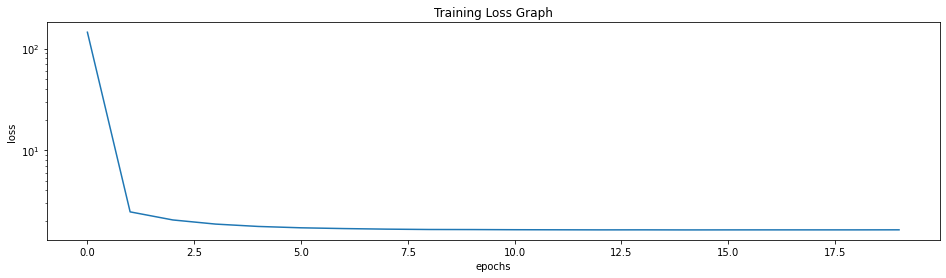

In [17]:
## load
with open('model.pt', 'rb') as f:
    SAVED_MODEL = torch.load(f)

MODEL.load_state_dict(SAVED_MODEL['state'])

plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL["loss_history"])
plt.show()

In [18]:
%%time
# inference 함수는 데이터를 순차적으로 보면서 모델이 예측한 값과 실제 값의 차를 구해서 기록
def inference(dataset, model, batch_size):
    
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (np.concatenate(ts), np.concatenate(dist), np.concatenate(att))

CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_VALIDATION, MODEL, batch_size)

# 검증 데이터셋 전체 시간대에 대해 모든 필드의 |예측값 - 실제값|
print('CHECK_DIST shape:', CHECK_DIST.shape)
# 공격 여부 판단을 위해 같은 시각에서 전체 필드가 산출하는 차의 평균을 계산
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

CHECK_DIST shape: (86311, 41)
CPU times: user 12.2 s, sys: 111 ms, total: 12.3 s
Wall time: 16.7 s


In [ ]:
# ## 3등 솔루션
# # anomaly score median filter 정의
# def moving_median(x, n= 10):
#     a = []
#     for i in range(n):
#         a.append(np.concatenate([x[i:].copy(), np.zeros([i])]))
#     median_ANOMALY_SCORE = np.stack(a)
#     median_ANOMALY_SCORE.sort(0)
#     # data leakage를 방지하기 위해 n만큼 shift해서 반환
#     return np.concatenate([np.zeros([n]), median_ANOMALY_SCORE[n//2][:-n]])

# # data leakage 방지를 위해 이전 데이터에 대해서만 moving median 계산
# # 최종 anomaly score (median_ANOMALY_SCORE)
# FILTER_SIZE = 5
# median_ANOMALY_SCORE = moving_median(ANOMALY_SCORE, n= FILTER_SIZE)


In [19]:
# from transformer solution, https://dacon.io/competitions/official/235757/codeshare/3244?page=1&dtype=recent
def range_check(series, size):
    data = []
    
    for idx in range(size-1):
        data.append(series[idx])

    for i in range(size, len(series)+1):
        if i == size :
            check_std = np.std(series[i-size:i])
        std = np.std(series[i-size:i])
        mean = np.mean(series[i-size:i])
        max = np.max(series[i-size:i])
        check_std
        if check_std * 2 >= std:
            check_std = std
            data.append(mean)
        elif max == series[i]:
            data.append(max*5)
            check_std = std
        else:
            data.append(series[i]*3)
    #for _ in range(size-1):
    #    data.append(mean)

    return np.array(data)    
    
    

ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)
C_ANOMALY_SCORE = range_check(ANOMALY_SCORE, size=30)
print(C_ANOMALY_SCORE.shape)

(86311,)


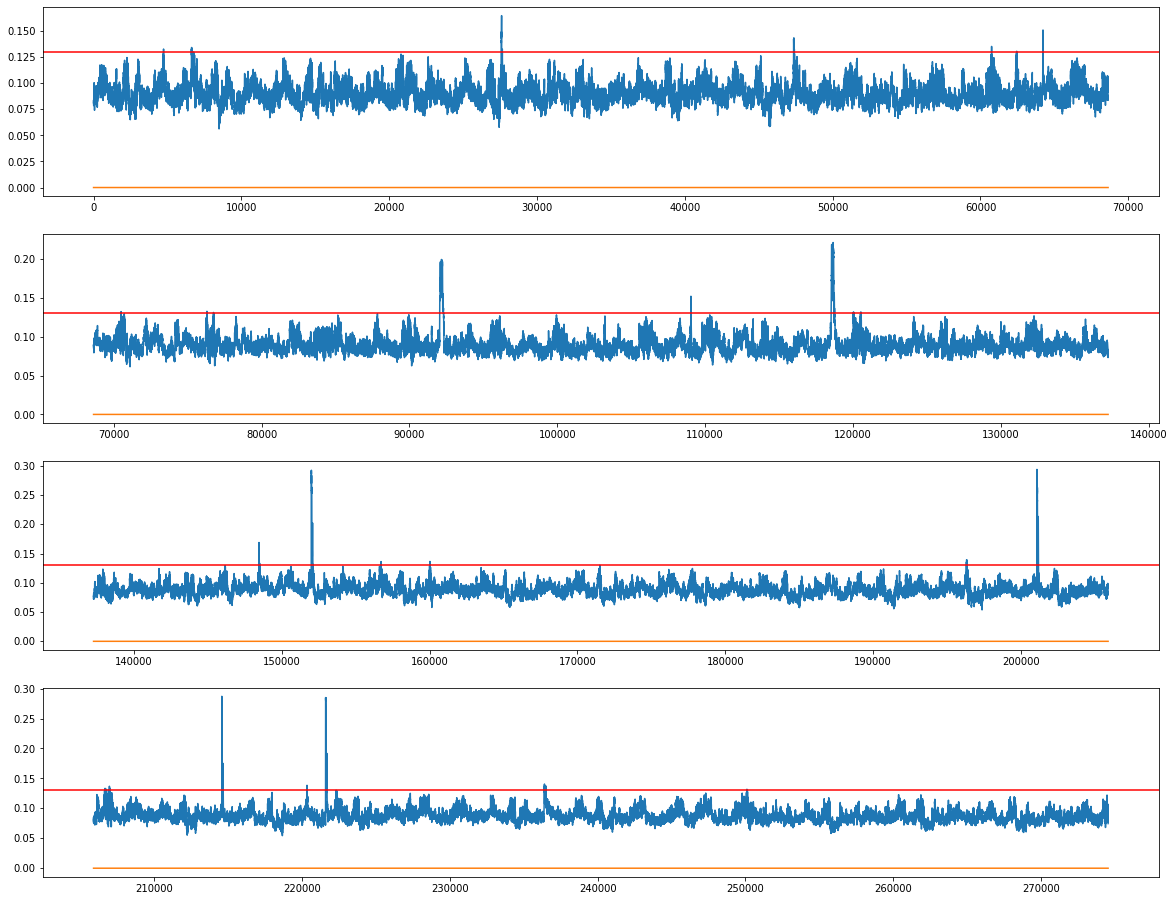

In [34]:
## 결과 확인
# 주황색 선은 공격 위치를 나타내고, 파란색 선은 (평균) 오차의 크기를 나타냅니다. 전반적으로 공격 위치에서 큰 오차
# piece: 그래프를 몇개로 나누어 그릴지
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()
    

THRESHOLD = 0.13
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=4, THRESHOLD=THRESHOLD)



In [26]:
## threshold로 공격 검출
# 대략 0.13를 기준으로 설정
# 여러 번의 실험을 통해 정밀하게 임계치를 선택
# 임의의 threshold(빨간색 선)가 넘어갈 경우 공격으로 간주합니다. 공격은 1로 정상은 0으로 표기
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
print(LABELS, LABELS.shape)

# 정답지(ATTACK_LABELS)도 동일하게 추출, 검증 데이터셋에 공격 여부를 나타내는 필드에는 정상을 0으로 공격을 1로 표기
# 0.5를 기준으로 같은 방식으로 TaPR을 위한 label
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
print(ATTACK_LABELS, ATTACK_LABELS.shape)

[0. 0. 0. ... 0. 0. 0.] (86311,)
[0 0 0 ... 0 0 0] (86400,)


In [27]:
## 결과 정리
'''
탐지 모델이 윈도우 방식으로 판단을 진행했기 때문에,
1. 첫 시작의 몇 초는 판단을 내릴 수 없고
2. 데이터셋 중간에 시간이 연속되지 않는 구간에 대해서는 판단을 내릴 수 없습니다.

위에서 보시는 바와 같이 정답에 비해 얻어낸 label의 수가 적습니다.

아래의 fill_blank 함수는 빈칸을 채워줍니다.
빈 곳은 정상(0) 표기하고 나머지는 모델의 판단(정상 0, 비정상 1)을 채워줍니다.
'''

def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)
    
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
print(FINAL_LABELS.shape)

(86400,)


## 6_Evaluation

평가 metric은 TaPR을 사용
정답(ATTACK_LABELS)과 모델의 결과(FINAL_LABELS)의 길이가 같은지 확인

In [28]:
TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.028 (TaP: 0.020, TaR: 0.051)
# of detected anomalies: 1
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7fa3e8c5d110>]


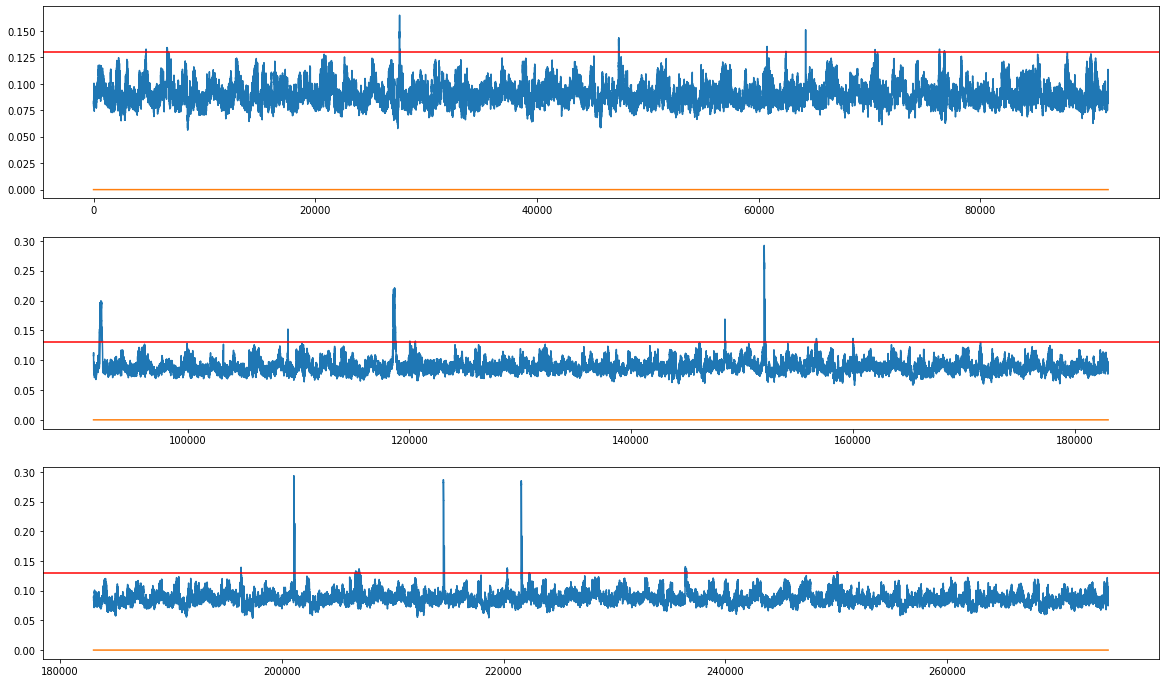

[0. 0. 0. ... 0. 0. 0.] (274533,)
CPU times: user 44.9 s, sys: 500 ms, total: 45.4 s
Wall time: 45.7 s


In [29]:
%%time
# inference 함수로 데이터를 순차적으로 보면서 모델이 예측한 값과 실제 값의 차를 구해서 기록
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, MODEL, batch_size)

# 공격 여부 판단을 위해 같은 시각에서 전체 필드가 산출하는 차의 평균을 계
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)
# 결과를 눈으로 확인하기 위해 그래프
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=3, THRESHOLD=THRESHOLD)
# 검증 데이터셋을 이용해 찾은 threshold를 이용해 공격 여부를 예측
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
print(LABELS, LABELS.shape)

# 예측한 결과를 제출양식에 맞춰 저장
submission = pd.read_csv('data/sample_submission.csv')
submission.index = submission['timestamp']
submission.loc[CHECK_TS,'attack'] = LABELS
submission.to_csv('baseline.csv', index=False)
submission

## 7_수상 솔루션!

#####  1등 solution, [url](https://dacon.io/competitions/official/235624/codeshare/1830?page=1&dtype=recent)
- WINDDOW 사이즈가 각각 다른 9개의 모델을 각각 만든다
- 9개중 한 모델이라도 이상을 탐지하면 비정상으로 분류

```
def Cross_put_labels(Inverse1, Inverse2, Inverse3, Inverse4, Inverse5, Inverse6, Inverse7, Inverse8, Inverse9):
    xs = np.zeros_like(Inverse1)
    for i in range(Inverse1.shape[0]):
        if Inverse1[i] + Inverse2[i] + Inverse3[i] + Inverse4[i] + Inverse5[i] + Inverse6[i] + Inverse7[i] + Inverse8[i] + Inverse9[i] > 0:
            xs[i] = 1
        else:
            xs[i] = 0
    return xs

################################################################################
Cross_LABELS = Cross_put_labels(Final_LABELS1, Final_LABELS2, Final_LABELS3, Final_LABELS4, Final_LABELS5, Final_LABELS6, Final_LABELS7, Final_LABELS8, Final_LABELS9)
#check_graph(Cross_LABELS, CHECK_ATT5, piece=2)

submission = pd.read_csv('data/HAI 2.0/sample_submission.csv') # ------------------ Check
submission.index = submission['time']
submission.loc[TEST_DF_RAW[TIMESTAMP_FIELD],'attack'] = Cross_LABELS
submission
submission.to_csv("output(Create_submit)/Final_Cross_baseline(nine parallel).csv", index=False) # ------------------ Check
```

##### 2등 solution, [url](https://dacon.io/competitions/official/235624/codeshare/1831?page=1&dtype=recent)
- keras, Bidirectional lstm 3층
- WINDOW 10짜리와 60짜리를 조합
- Gray Area Smoothing, moving average를 적절히 사용

```
def Gray_Area(attacks):
    start = []  # start point
    finish = []  # finish point
    c = []  # count
    com = 0
    count = 0
    for i in range(1, len(attacks)):
        if attacks[i - 1] != attacks[i]:
            if com == 0:
                start.append(i)
                count = count + 1
                com = 1
            elif com == 1:
                finish.append(i - 1)
                c.append(count)
                count = 0
                start.append(i)
                count = count + 1
        else:
            count = count + 1

    finish.append(len(attacks) - 1)
    c.append(finish[len(finish) - 1] - start[len(start) - 1] + 1)

    for i in range(0, len(start)):
        if c[i] < 10:
            s = start[i]
            f = finish[i] + 1
            g1 = [1 for i in range(c[i])] # Temp Attack list
            g0 = [0 for i in range(c[i])]  # Temp Normal List
            if attacks[start[i] - 1] == 1:
                attacks[s:f] = g1  # change to attack
            else:
                attacks[s:f] = g0  # change to normal

    return attacks

gray_LABELS_60seq=Gray_Area(LABELS_60seq)



## MOVING AVERAGE
seq60_10mean=[]
for idx in range(len(ANOMALY_SCORE)):
    if idx >= 10:
        seq60_10mean.append((ANOMALY_SCORE[idx-10:idx].mean()+ANOMALY_SCORE[idx])/2)
    else:
        seq60_10mean.append(ANOMALY_SCORE[idx])

seq60_10mean=np.array(seq60_10mean)
print(seq60_10mean.shape)
```

##### 3등 solution [url](https://dacon.io/competitions/official/235624/codeshare/1832?page=1&dtype=recent)
- 예측 결과에 moving average
- WINDOW size는 그대로 90
- 모델에 batch_normalization과 Relu non linear func 사용
```
out = F.relu(self.bn(outs[:, -1]))
out = self.fc(out)
```